In [50]:
from lib.Agents import *
from lib.Demand import *

In [87]:
from collections import deque
import numpy as np

def get_distance(lat1, lng1, lat2, lng2):
    return np.sqrt( (lat1 - lat2)**2 + (lng1 - lng2)**2 )

class Veh(object):
    """ 
    Veh is a class for vehicles
    Attributes:
        id: sequential unique id
        T: system time at current state
        lat: current latitude
        lng: current longitude
        tlat: target (end of route) latitude
        tlng: target (end of route) longitude
        K: capacity
        n: number of passengers on board
        jobs: a list of jobs in the format of (request id, pickup or dropoff, target lat, target lng)
        S: speed
    """ 
    def __init__(self, id, T=0.0, lat=0.5, lng=0.5, K=1, S=0.01):
        self.id = id
        self.T = T
        self.lat = lat
        self.lng = lng
        self.tlat = lat
        self.tlng = lng
        self.K = K
        self.n = 0
        self.jobs = deque([])
        self.S = S
        
    def get_location(self):
        return (self.lat, self.lng)
    
    def move_to_location(self, lat, lng):
        self.lat = lat
        self.lng = lng
        
    def is_idle(self):
        if len(self.jobs) == 0:
            return True
        elif len(self.jobs) == 1 and self.jobs[0][0] == -1 and self.jobs[0][1] == 0:
            return True
        else:
            return False 
        
    def move_to_time(self, T):
        dT = T - self.T
        assert dT >= 0
        done = []
        while dT > 0 and len(self.jobs) > 0:
            j = self.jobs[0]
            d = get_distance(self.lat, self.lng, j[2], j[3])
            t = d / self.S
            if t < dT:
                dT -= t
                self.T += t
                self.n += j[1]
                self.move_to_location(j[2], j[3])
                done.append( (j[0], j[1], self.T) )
                self.jobs.popleft()
            else:
                pct = dT / t
                lat_ = self.lat + pct * (j[2] - self.lat)
                lng_ = self.lng + pct * (j[3] - self.lng)
                self.move_to_location(lat_, lng_)
                break
        self.T = T
        return done 
    
    def draw(self):
        plt.plot(self.lat, self.lng, 'b', marker='o')
        slat = self.lat
        slng = self.lng
        for l in range(len(self.jobs)):
            elat = self.jobs[l][2]
            elng = self.jobs[l][3]
            if self.jobs[l][1] == 1:
                plt.plot([slat, elat], [slng, elng], 'b', linestyle='-')
                plt.plot(elat, elng, 'b', marker='s')
            elif self.jobs[l][1] == -1:
                plt.plot([slat, elat], [slng, elng], 'b', linestyle='-')
                plt.plot(elat, elng, 'b', marker='*')
            elif self.jobs[l][1] == 0:
                plt.plot([slat, elat], [slng, elng], 'b', linestyle=':')
            slat = elat
            slng = elng
                        
    def __str__(self):
        str =  "veh %d at (%.7f, %.7f) when t = %.3f; occupancy = %d/%d" % (
            self.id, self.lat, self.lng, self.T, self.n, self.K)
        for j in self.jobs:
            str += "\n    %s: req %d at (%.7f, %.7f)" % ("pickup" if j[1] > 0 else "dropoff", j[0], j[2], j[3])
        return str
    

class Req(object):
    """ 
    Req is a class for requests
    Attributes:
        id: sequential unique id
        Tr: request time
        Tp: pickup time
        Td: dropoff time
        olat: origin latitude
        olng: origin longitude
        dlat: destination latitude
        dlng: destination longitude
    """
    def __init__(self, id, Tr, olat=0.115662, olng=51.374282, dlat=0.089282, dlng=51.350675):
        self.id = id
        self.Tr = Tr
        self.Tp = -1.0
        self.Td = -1.0
        self.olat = olat
        self.olng = olng
        self.dlat = dlat
        self.dlng = dlng
    
    def get_origin(self):
        return (self.olat, self.olng)
    
    def get_destination(self):
        return (self.dlat, self.dlng)
    
    def draw(self):
        plt.plot(self.olat, self.olng, 'r', marker='s')
        plt.plot(self.dlat, self.dlng, 'r', marker='*')
        plt.plot([self.olat, self.dlat], [self.olng, self.dlng], 'r', linestyle='--', dashes=(0.5,1.5))
    
    def __str__(self):
        return "req %d from (%.7f, %.7f) to (%.7f, %.7f) at t = %.3f" % (
            self.id, self.olat, self.olng, self.dlat, self.dlng, self.Tr)
    

class Model(object):
    """
    Model is the class for the AMoD system
    Attributes:
        T: system time at current state
        D: average arrival interval (sec)
        demand: demand matrix
        V: number of vehicles
        K: capacity of vehicles
        vehs: the list of vehicles
        N: number of requests
        reqs: the list of requests
        queue: requests in the queue
    """ 
    def __init__(self, D, demand, V=10, K=1):
        self.T = 0.0
        self.D = D
        self.demand = demand
        self.V = V
        self.K = K
        self.vehs = []
        for i in range(V):
            self.vehs.append( Veh(i, lat=np.random.rand(), lng=np.random.rand(), K=K) )
        self.N = 0
        self.reqs = []
        self.queue = deque([])
        
    def generate_request(self):
        dt = self.D * np.random.exponential()
        rand = np.random.rand()
        for d in demand:
            if d[4] > rand:
                req = Req(0 if self.N == 0 else self.reqs[-1].id+1,
                          dt if self.N == 0 else self.reqs[-1].Tr+dt,
                          d[1], d[0], d[3], d[2])
                break
        self.N += 1
        return req
        
    def generate_requests_to_time(self, T):
        if self.N == 0:
            req = self.generate_request()
            self.reqs.append(req)
        while self.reqs[-1].Tr <= T:
            req = self.generate_request()
            self.queue.append(self.reqs[-1])
            self.reqs.append(req)
        assert self.N == len(self.reqs)
        
    def dispatch_at_time(self, T):
        for v in self.vehs:
            done = v.move_to_time(T)
            for d in done:
                if d[1] == 1:
                    self.reqs[ d[0] ].Tp = d[2]
                elif d[1] == -1:
                    self.reqs[ d[0] ].Td = d[2]
        self.generate_requests_to_time(T)
        self.T = T
        print(self)
        self.assign()
        for v in self.vehs:
            print(v)
        
    def assign(self):
        l = len(self.queue)
        for i in range(l):
            req = self.queue.popleft()
            if not self.insert_nearest(req):
                self.queue.append(req)
        
    def insert_nearest(self, req):
        d_ = np.inf
        v_ = None
        for v in self.vehs:
            if v.is_idle():
                d = get_distance(v.lat, v.lng, req.olat, req.olng)
                if d < d_:
                    d_ = d
                    v_ = v
        if v_ == None:
            return False
        else:
            v_.jobs.clear()
            v_.jobs.append( (req.id, 1, req.olat, req.olng) )
            v_.jobs.append( (req.id, -1, req.dlat, req.dlng) )
            v_.tlat = req.dlat
            v_.tlng = req.dlng
            return True  
    
    def draw(self):
        plt.figure(figsize=(10,10))
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        for v in self.vehs:
            v.draw()
        for r in self.queue:
            r.draw()
        plt.show()
        
    def __str__(self):
        str = "AMoD system: %d vehicles of capacity %d; %.1f trips/h" % (self.V, self.K, 3600/self.D)
        str += "\n  at t = %.3f, %d requests, in which %d in queue" % ( self.T, self.N-1, len(self.queue) )
        for r in self.queue:
            str += "\n    " + r.__str__()
        return str

In [108]:
model = Model(1, demand, V=10)

In [109]:
T = 0

AMoD system: 10 vehicles of capacity 1; 3600.0 trips/h
  at t = 40.000, 46 requests, in which 36 in queue
    req 10 from (0.1776987, 0.7952032) to (0.3474168, 0.5067944) at t = 13.357
    req 11 from (0.8791476, 0.3619095) to (0.4460823, 0.6846173) at t = 14.309
    req 12 from (0.5577380, 0.6489467) to (0.8435776, 0.3970683) at t = 14.864
    req 13 from (0.4715429, 0.6128970) to (0.6230252, 0.7440851) at t = 15.139
    req 14 from (0.3716803, 0.4108907) to (0.3635200, 0.4168244) at t = 15.650
    req 15 from (0.3697666, 0.3388539) to (0.3463337, 0.5464335) at t = 16.144
    req 16 from (0.3622924, 0.5158040) to (0.5496331, 0.5278102) at t = 16.144
    req 17 from (0.3890390, 0.1715900) to (0.4098765, 0.4582493) at t = 16.162
    req 18 from (0.6593001, 0.2835104) to (0.8497354, 0.8500440) at t = 16.188
    req 19 from (0.5455820, 0.2431173) to (0.2046965, 0.1785481) at t = 18.000
    req 20 from (0.5992425, 0.5716825) to (0.6322638, 0.3862398) at t = 18.058
    req 21 from (0.271546

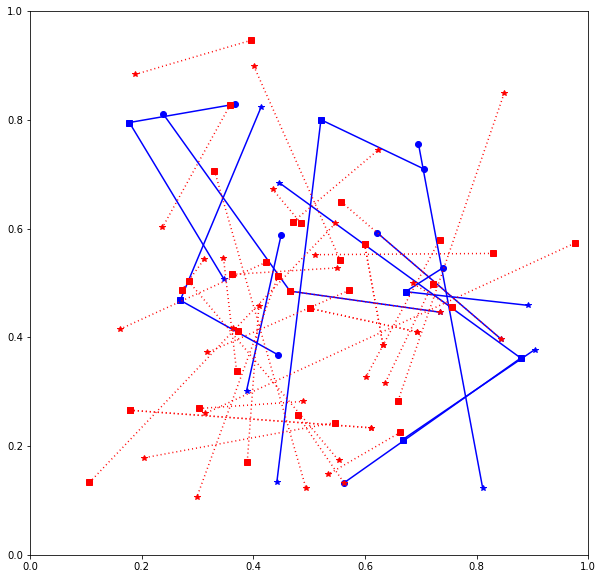

In [114]:
model.dispatch_at_time(T)
model.draw()
T += 10

In [ ]:
demand = []
for i in range(100):
    lat1 = np.random.triangular(0, 0.5, 1)
    lat2 = np.random.triangular(0, 0.5, 1)
    lng1 = np.random.triangular(0, 0.5, 1)
    lng2 = np.random.triangular(0, 0.5, 1)
    demand.append( (lat1, lng1, lat2, lng2, (i+1)/100) )
demand